# Importing Libraries

__NOTE:__ Training cell output is cleared from notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Building Artificial Neural Network (Very Basic)

## Hyperparameters

In [2]:
batch_size = 64
learning_rate = 1e-3
epochs = 150

## Downloading and preprocessing data

In [3]:
base_folder = './data'
fashion_mnist_train = datasets.FashionMNIST(base_folder, download = True, train = True)
fashion_mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [4]:
train_images, train_labels = fashion_mnist_train.data, fashion_mnist_train.targets
print(f"Number of Training Images: {len(train_images)}")
print(train_images.shape, train_labels.shape)

Number of Training Images: 60000
torch.Size([60000, 28, 28]) torch.Size([60000])


In [5]:
print(f"Classes present in dataset: \n{fashion_mnist_train.classes}")

Classes present in dataset: 
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


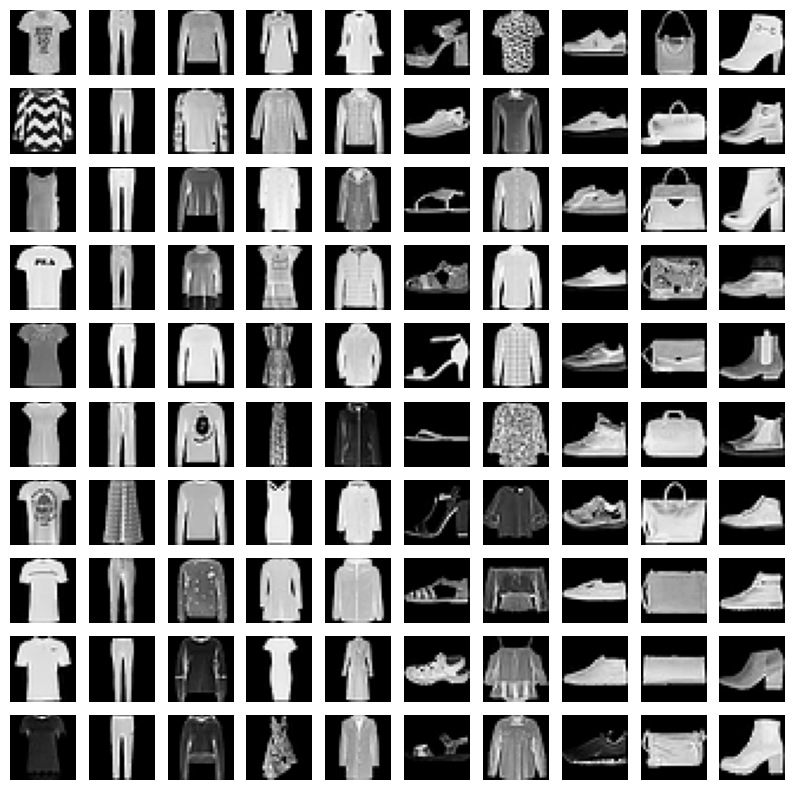

In [6]:
# Visualizing Data
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

In [7]:
fashion_mnist_valid = datasets.FashionMNIST(base_folder, download = True, train = False)
fashion_mnist_valid

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [8]:
valid_images, valid_labels = fashion_mnist_valid.data, fashion_mnist_valid.targets
print(f"Number of Valid Images: {len(valid_images)}")
print(valid_images.shape, valid_labels.shape)

Number of Valid Images: 10000
torch.Size([10000, 28, 28]) torch.Size([10000])


## Helper functions for training

In [9]:
class FMNISTDataset(Dataset):
    def __init__(self, imgs, lbls):
        # Flattening image
        self.imgs = imgs
        self.lbls = lbls
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img, lbl = self.imgs[idx], self.lbls[idx]
        
        # Normalize input image to be in between 0-1
        img = img / 255.
        
        # Flattening 2D image into a vector
        img = img.view(-1)
        return img, lbl

In [10]:
def get_data(bs = 64):
    train_data = FMNISTDataset(train_images, train_labels)
    trainloader = DataLoader(train_data, batch_size = bs, shuffle = True)
    valid_data = FMNISTDataset(valid_images, valid_labels)
    validloader = DataLoader(valid_data, batch_size = bs)
    return trainloader, validloader

def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr)
    return model, criterion, optimizer

def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    batch_loss = criterion(out, lbls)
    if not valid:
        batch_loss.backward()
        optimizer.step()
    return batch_loss.item()

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [11]:
def train(epochs, learning_rate):
    trainloader, validloader = get_data(batch_size)
    model, criterion, optimizer = build_model(learning_rate)
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        print(f"{'*'*10} EPOCH {epoch:2}/{epochs-1} {'*'*10}")
        batch_loss = 0.0
        model.train()
        for imgs, lbls in trainloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
        
    return train_losses, train_accuracies, valid_losses, valid_accuracies

## Training

In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

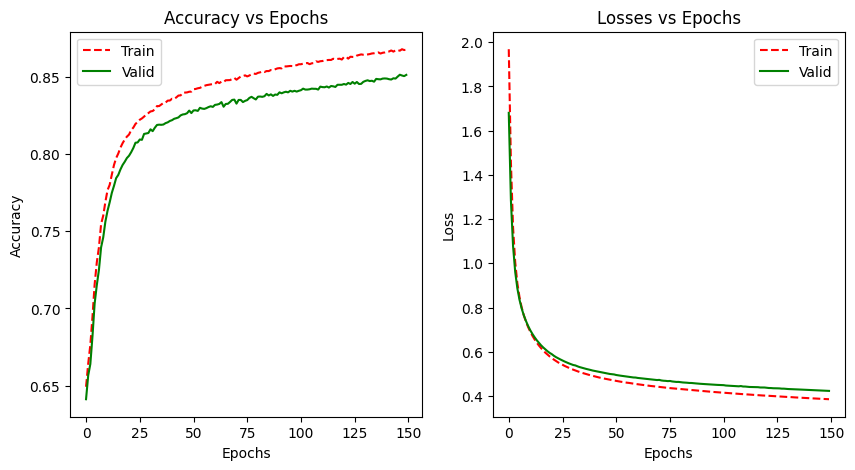

In [15]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

# Hyperparams tuning

## 1.) Changing Optimizer

In [16]:
def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                         nn.ReLU(),
                         nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

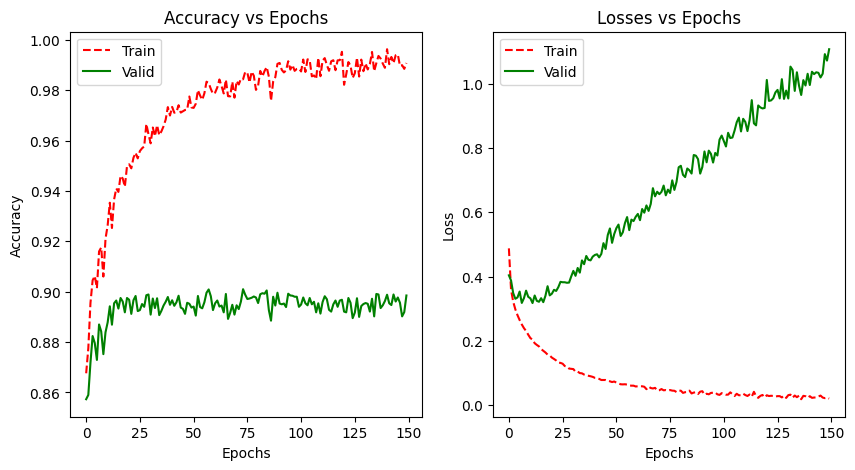

In [18]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

Note: Overfitting occurs due to running for so many epochs. Also valid accuracy is good compared to using sgd.

## 2.) Changing learning rate

### Learning Rate = 0.01

In [ ]:
epochs = 100
learning_rate = 1e-02
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

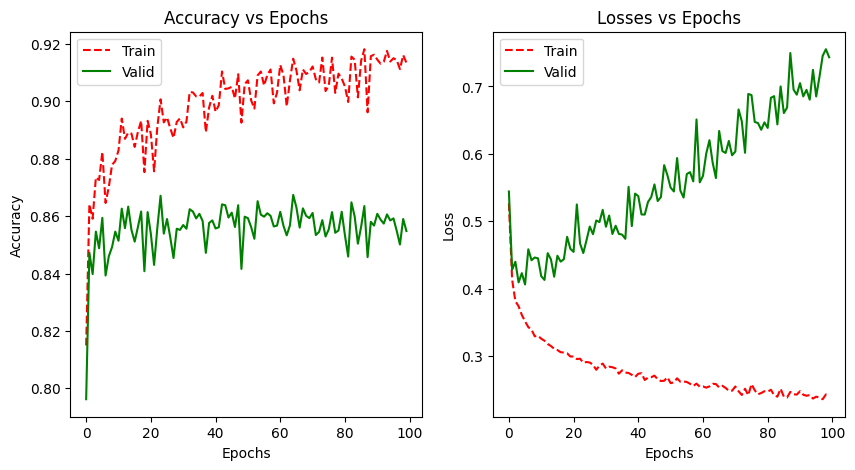

In [20]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

### Learning Rate = 0.0001

In [ ]:
epochs = 100
learning_rate = 1e-04
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

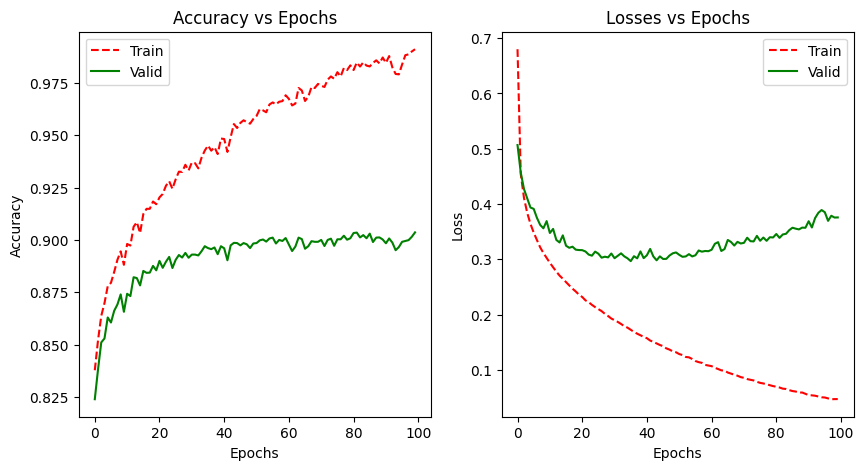

In [23]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

### Learning Rate = 0.00001

In [ ]:
epochs = 100
learning_rate = 1e-05
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

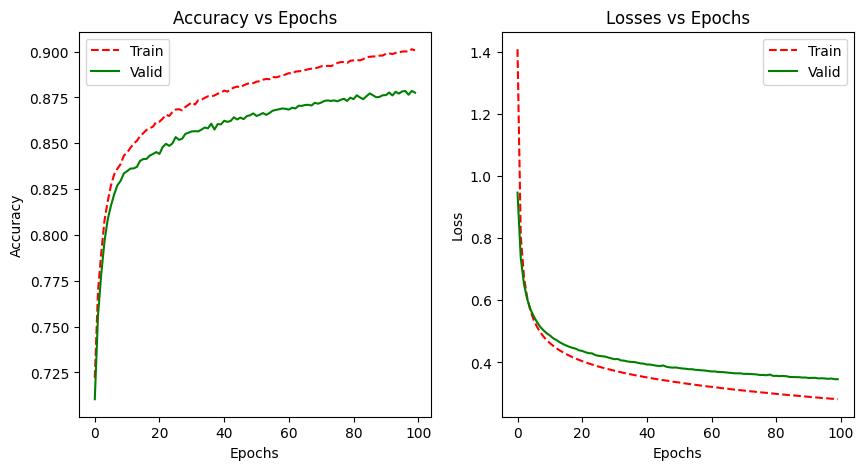

In [25]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

NOTE: Learning rate >= 0.01 causes lots of fluctuation in loss (diverging) hence smaller learning rate have to be tried, whereas smaller learning rate reduces loss slowly and thus its performance grows slowly and therefore less overfitting. Learning rate of 1e-03 works well.

## 3.) Addressing overfitting

### Batch Normalization

In [12]:
def build_model(lr = 1e-03):
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Linear(28*28, 1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(),
                          nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
epochs = 100
learning_rate = 1e-03
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

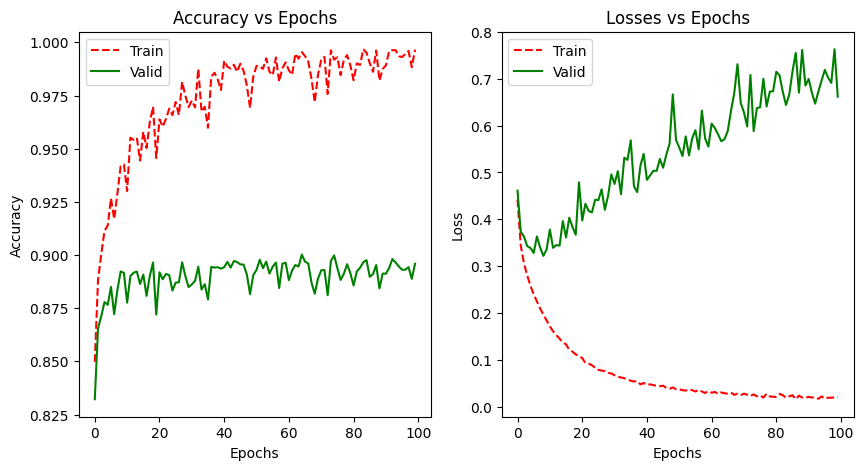

In [14]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

NOTE: Though it gives great result on training data ~ 100% accuracy but it overfitting so batch norm doesn't acts as a very strong regularizer. So to counter overfitting strong regularizer has to be used (such as dropout or L1,L2 regularizer)

Also since we have achieved 100% accuracy on training data => this model is strong enough for classifying fashion mnist data

### Applying Dropout

In [31]:
def build_model(lr = 1e-03):
    p = 0.6
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Dropout(p),
                          nn.Linear(28*28, 1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
epochs = 100
learning_rate = 1e-03
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

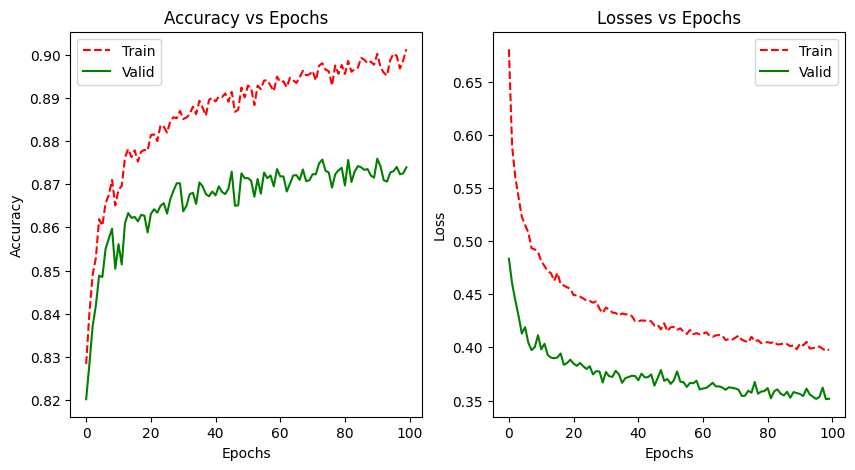

In [29]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

NOTE: Still there is a slight overfitting for p = 0.6, increasing it further reduces overfitting but deteriorates model performance. Let's try another regularization with dropout for overfitting. I will go with p = 0.5 since there is L1/L2 regularization also at play

### L1 Regularization

In [39]:
def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    L1_reg = 0.0
    for parameter in model.parameters():
        L1_reg += torch.norm(parameter, 1)
    batch_loss = criterion(out, lbls)
    if not valid:
        _lamda = 0.00001
        final_loss = batch_loss + _lamda * L1_reg # _lambda is regularization hyperparam
        final_loss.backward()
        optimizer.step()
    return batch_loss.item()

def build_model(lr = 1e-03):
    p = 0.5
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Dropout(p),
                          nn.Linear(28*28, 1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
epochs = 100
learning_rate = 1e-03
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

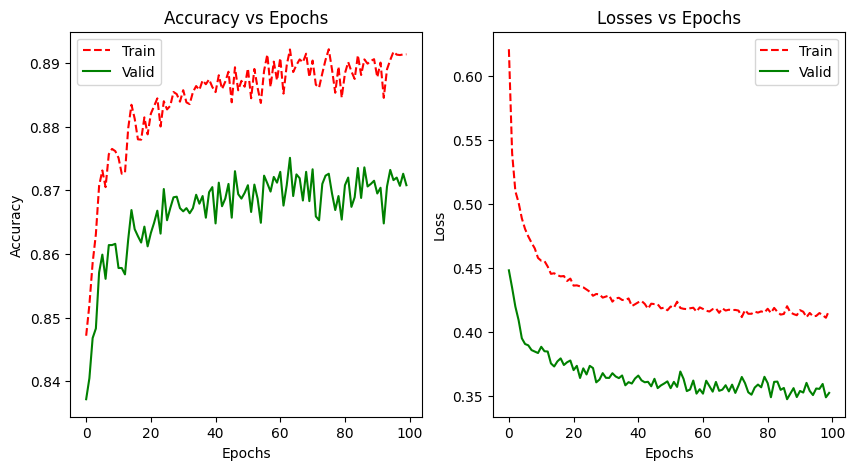

In [42]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

Further decreasing lamda value may lead to more overfitting and increasing it will lead to degrading performance

### L2 Regularization

In [43]:
def train_batch(imgs, lbls, model, criterion, optimizer, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device), lbls.to(device), model.to(device)
    out = model(imgs)
    L2_reg = 0.0
    for parameter in model.parameters():
        L2_reg += torch.norm(parameter, 2)
    batch_loss = criterion(out, lbls)
    if not valid:
        _lamda = 0.0001
        final_loss = batch_loss + _lamda * L2_reg # _lambda is regularization hyperparam
        final_loss.backward()
        optimizer.step()
    return batch_loss.item()

def build_model(lr = 1e-03):
    p = 0.5
    # Creating simple model with 1 hidden layer
    model = nn.Sequential(nn.Dropout(p),
                          nn.Linear(28*28, 1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(),
                          nn.Dropout(p),
                          nn.Linear(1000, 10))
    criterion = nn.CrossEntropyLoss()
    
    # Made changes in optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
    return model, criterion, optimizer

In [ ]:
epochs = 100
learning_rate = 1e-03
train_losses, train_accuracies, valid_losses, valid_accuracies = train(epochs, learning_rate)

********** EPOCH  0/99 **********
#################################
Train Loss: 0.621, Train Accuracy: 84.69
Valid Loss: 0.452, Valid Accuracy: 83.43
#################################
********** EPOCH  1/99 **********
#################################
Train Loss: 0.533, Train Accuracy: 85.06
Valid Loss: 0.436, Valid Accuracy: 83.88
#################################
********** EPOCH  2/99 **********
#################################
Train Loss: 0.502, Train Accuracy: 86.50
Valid Loss: 0.403, Valid Accuracy: 85.34
#################################
********** EPOCH  3/99 **********
#################################
Train Loss: 0.481, Train Accuracy: 87.11
Valid Loss: 0.395, Valid Accuracy: 85.66
#################################
********** EPOCH  4/99 **********
#################################
Train Loss: 0.470, Train Accuracy: 87.31
Valid Loss: 0.392, Valid Accuracy: 86.09
#################################
********** EPOCH  5/99 **********
#################################
Train Loss: 

#################################
Train Loss: 0.364, Train Accuracy: 90.64
Valid Loss: 0.334, Valid Accuracy: 87.92
#################################
********** EPOCH 46/99 **********
#################################
Train Loss: 0.358, Train Accuracy: 90.55
Valid Loss: 0.336, Valid Accuracy: 87.66
#################################
********** EPOCH 47/99 **********
#################################
Train Loss: 0.362, Train Accuracy: 91.00
Valid Loss: 0.329, Valid Accuracy: 88.34
#################################
********** EPOCH 48/99 **********
#################################
Train Loss: 0.363, Train Accuracy: 90.90
Valid Loss: 0.326, Valid Accuracy: 88.34
#################################
********** EPOCH 49/99 **********
#################################
Train Loss: 0.358, Train Accuracy: 91.04
Valid Loss: 0.329, Valid Accuracy: 88.18
#################################
********** EPOCH 50/99 **********
#################################
Train Loss: 0.359, Train Accuracy: 90.83
Valid

#################################
Train Loss: 0.341, Train Accuracy: 91.91
Valid Loss: 0.318, Valid Accuracy: 88.82
#################################
********** EPOCH 91/99 **********
#################################
Train Loss: 0.342, Train Accuracy: 91.78
Valid Loss: 0.316, Valid Accuracy: 88.58
#################################
********** EPOCH 92/99 **********
#################################
Train Loss: 0.340, Train Accuracy: 91.64
Valid Loss: 0.322, Valid Accuracy: 88.38
#################################
********** EPOCH 93/99 **********
#################################
Train Loss: 0.338, Train Accuracy: 91.79
Valid Loss: 0.318, Valid Accuracy: 88.75
#################################
********** EPOCH 94/99 **********
#################################
Train Loss: 0.340, Train Accuracy: 91.68
Valid Loss: 0.323, Valid Accuracy: 88.58
#################################
********** EPOCH 95/99 **********
#################################
Train Loss: 0.341, Train Accuracy: 91.85
Valid

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();